In [1]:
from sklearn.neighbors import NearestCentroid, KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, CategoricalNB, ComplementNB
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.tree import ExtraTreeClassifier, DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from skimage.exposure import histogram
from skimage import io
from skimage.filters import threshold_otsu, laplace
from skimage.color import rgb2gray

from scipy.signal import convolve2d

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import csv

In [2]:
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

def showHist(img):
    # An "interface" to matplotlib.axes.Axes.hist() method
    plt.figure()
    imgHist = histogram(img, nbins=256)
    
    plt.bar(imgHist[1].astype(np.uint8), imgHist[0], width=0.8, align='center')

In [3]:
def read_data(file_name):
    ## HINT 1: How is the data ordered in the file?
    ## HINT 2: Do you need to cast the data you read from the file?
    data = []
    with open(file_name, newline='') as csv_file:
        spamreader = csv.reader(csv_file, delimiter=' ', quotechar='|')
        for row in spamreader:
            data.append([float(element) for element in row[0].split(',')])
    return data

In [4]:
def read_test_data():
    
    # TODO [2.A]: Read the file 'test_data.csv' into the variable test_data
    # test_data contains the unlabelled test class.
    ## HINT: Do you need to cast the data you read from the file?

    test_data = read_data('validating_data.csv')
    
    # TODO [2.B]: Read the file 'test_data_true.csv' into the variable test_data_true
    # test_data_true contains the actual classes of the test instances, which you will compare
    # against your predicted classes.
    ## HINT: Do you need to cast the data you read from the file?

    test_data_true = []
    with open('./true_validating_data.csv', newline='') as csv_file:
        spamreader = csv.reader(csv_file, delimiter=' ', quotechar='|')
        for row in spamreader:
            test_data_true.append(float(row[0]))
            
    return test_data, test_data_true

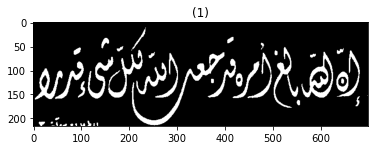

In [29]:
def preprocessing_image(img):
    '''
    DESCRIPTION:
    Preprocess an image.
        1. Grayscale
        2. OTSU Threshold
        3. Binarization
        4. Checking image binary is 0 or 255
        5. Laplacian filter
    
    RETURN:
    Preprocessd Image
    '''
    grayscale_image = rgb2gray(img)
    if grayscale_image.max() <= 1:
        grayscale_image = (grayscale_image * 255)
    grayscale_image = grayscale_image.astype(np.uint8)
    
    global_threshold = threshold_otsu(grayscale_image)
    binary_image = np.where(grayscale_image > global_threshold, 255, 0)
    # binary_image = grayscale_image > global_threshold
    
    image_histogram = np.asarray(histogram(binary_image, nbins=256))
    if image_histogram.argmax() <= 150:
        binary_image = 255 - binary_image
    binary_image = np.where(binary_image > 0, 0, 1)
    binary_image = binary_image.astype(np.uint8)
    
    show_images([binary_image])
    return binary_image

img = io.imread("..\\..\\data\\raw\\1\\0001.jpg")
processed = preprocessing_image(img)
# x = lpq(processed,winSize=3,freqestim=3,mode='nh')

In [6]:
def lpq(img, winSize=3, freqestim=1):

    # alpha in STFT approaches (for Gaussian derivative alpha=1)
    STFTalpha = 1/winSize
    # Sigma for STFT Gaussian window (applied if freqestim==2)
    sigmaS = (winSize-1)/4
    # Sigma for Gaussian derivative quadrature filters (applied if freqestim==3)
    sigmaA = 8/(winSize-1)

    # Compute descriptor responses only on part that have full neigborhood.
    # Use 'same' if all pixels are included (extrapolates np.image with zeros).
    convmode = 'valid'

    # Convert np.image to double
    img = np.float64(img)
    # Get radius from window size
    r = (winSize-1)/2
    # Form spatial coordinates in window
    x = np.arange(-r, r+1)[np.newaxis]

    u = np.arange(1, r+1)

    # STFT uniform window
    if freqestim == 1:
        #  Basic STFT filters
        w0 = np.ones_like(x)
        w1 = np.exp(-2*np.pi*x*STFTalpha*1j)
        w2 = np.conj(w1)
    # STFT Gaussian window (equals to Gaussian quadrature filter pair)
    elif freqestim == 2:
        # Basic STFT filters
        w0 = (x * 0 + 1)
        w1 = np.exp(-2*np.pi*x*STFTalpha*1j)
        w2 = np.conj(w1)
        # Gaussian window
        gs = np.exp(- 0.5 * (x / sigmaS) ** 2) / \
            (np.multiply(np.sqrt(2 * np.pi), sigmaS))
        # Windowed filters
        w0 = np.multiply(gs, w0)
        w1 = np.multiply(gs, w1)
        w2 = np.multiply(gs, w2)
        # Normalize to zero mean
        w1 = w1 - np.mean(w1)
        w2 = w2 - np.mean(w2)
    # Gaussian derivative quadrature filter pair
    elif freqestim == 3:

        G0 = np.exp(- x ** 2 * (np.sqrt(2) * sigmaA) ** 2)

        G1_zeros = np.concatenate((np.zeros(len(u)), np.asarray([0])))
        G1 = np.asarray(
            [np.concatenate((G1_zeros, u * np.exp(- u ** 2 * sigmaA ** 2)))])
        
        # Normalize to avoid small numerical values (do not change the phase response we use)
        G0 = G0 / np.max(np.abs(G0))
        G1 = G1 / np.max(np.abs(G1))
        
        # Compute spatial domain correspondences of the filters
        w0 = np.real(np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(G0))))
        w1 = np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(G1)))
        w2 = np.conj(w1)
        
        # Normalize to avoid small numerical values (do not change the phase response we use)
        w0 = w0 / \
            np.max(
                np.abs(np.array([np.real(np.max(w0)), np.imag(np.max(w0))])))
        w1 = w1 / \
            np.max(
                np.abs(np.array([np.real(np.max(w1)), np.imag(np.max(w1))])))
        w2 = w2 / \
            np.max(
                np.abs(np.array([np.real(np.max(w2)), np.imag(np.max(w2))])))

    # Run filters to compute the frequency response in the four points. Store np.real and np.imaginary parts separately
    # Run first filter
    filterResp1 = convolve2d(convolve2d(img, w0.T, convmode), w1, convmode)
    filterResp2 = convolve2d(convolve2d(img, w1.T, convmode), w0, convmode)
    filterResp3 = convolve2d(convolve2d(img, w1.T, convmode), w1, convmode)
    filterResp4 = convolve2d(convolve2d(img, w1.T, convmode), w2, convmode)

    # Initilize frequency domain matrix for four frequency coordinates (np.real and np.imaginary parts for each frequency).
    freqResp = np.dstack([filterResp1.real, filterResp1.imag,
                          filterResp2.real, filterResp2.imag,
                          filterResp3.real, filterResp3.imag,
                          filterResp4.real, filterResp4.imag])

    # Perform quantization and compute LPQ codewords
    inds = np.arange(freqResp.shape[2])[np.newaxis, np.newaxis, :]
    LPQdesc = ((freqResp > 0)*(2**inds)).sum(2)

    LPQdesc = np.histogram(LPQdesc.flatten(), range(256))[0]

    LPQdesc = LPQdesc/LPQdesc.sum()

    return LPQdesc

# img = io.imread("..\\..\\data\\raw\\1\\0001.jpg")
# processed = preprocessing_image(img)
# x = lpq(processed,winSize=3,freqestim=3)


In [7]:
def features_training_validating(base_directory, training_percent):
    '''
    DESCRIPTION:
    Get array of images at specific directory. Directory is divied into M-sections. 
    Each section is divided in N-fonts. Then preprocess, extract features
    
    RETURN:
    Array of N-fonts of arrays of features/image
    [
        Font_X[
            FeatureImg1[...]
            FeatureImg2[...]
            FeatureImg3[...]
            ...
        ]
    ]
    '''
    
    training_features = [[] for x in range(0,9)]
    validating_features = [[] for x in range(0,9)]
    true_validation = [[] for x in range(0,9)]
    features = [[] for x in range(0,9)]
    for folder_num in range(1, 10):
        folder_path = base_directory + "\\" + str(folder_num)
        filenames = os.listdir(folder_path)
        
        for fn in filenames:
            path = os.path.join(folder_path, fn)
            img = io.imread(path)
            preprocessed_image = preprocessing_image(img)
            image_features = lpq(preprocessed_image,winSize=3,freqestim=2)
            features[folder_num - 1].append(image_features)
            
        features[folder_num - 1] = np.asarray(features[folder_num - 1])
        n_training = round(features[folder_num - 1].shape[0] * training_percent)
        training_features[folder_num - 1] = features[folder_num - 1][:n_training]
        validating_features[folder_num - 1] = features[folder_num - 1][n_training:]
        true_validation[folder_num - 1] = np.full((features[folder_num - 1][n_training:].shape[0], 1), folder_num)
        
    return np.asarray(training_features), np.asarray(validating_features), np.asarray(true_validation)

# training_features, validating_features, true_validation = features_training_validating("..\\..\\data\\raw", 1.0)
# print(training_features[0].shape, validating_features[0].shape, true_validation[0].shape)

In [15]:
base_directory = "..\\..\\data\\raw"
training_features, validating_features, true_validation = features_training_validating(base_directory, 0.8)

C:\Users\omar_\AppData\Local\Temp/ipykernel_3952/778711977.py:14: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  grayscale_image = rgb2gray(img)
C:\Users\omar_\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [355]:
open("training_data.csv","w").close()
for class_idx, class_features in enumerate(training_features):
    true_class = np.full((class_features.shape[0], 1), class_idx + 1)
    with open('training_data.csv', 'a') as csvfile:
        np.savetxt(csvfile, np.concatenate((true_class, np.asarray(class_features)), axis=1), delimiter=",")

In [356]:
open("validating_data.csv","w").close()
open("true_validating_data.csv","w").close()
for class_idx, class_features in enumerate(validating_features):
    with open('validating_data.csv', 'a') as csvfile:
        np.savetxt(csvfile, class_features, delimiter=",")
    
    with open('true_validating_data.csv', 'a') as csvfile:
        np.savetxt(csvfile, true_validation[class_idx], delimiter=",")

In [35]:
font_names = ['diwani', 'naskh', 'parsi', 'rekaa', 'thuluth', 'maghribi', 'kufi', 'mohakek', 'Squar-kufic']

In [36]:
training_data = np.asarray(read_data('training_data.csv'))
test_data, test_data_true = read_test_data()

In [37]:
nClasses = 9
M = len(training_data)
N = len(test_data[0])
K = len(test_data)

In [38]:
X = np.asarray(training_data)[:, 1:N + 1]
X_Test = np.asarray(test_data)
Y = np.asarray(training_data)[:, 0:1]

In [12]:
parameters = {'kernel':['poly'], 'C': np.asarray([1, 10, 19]), 'gamma': 
               np.asarray([0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 20, 53])}

clf = svm.SVC()
grid = GridSearchCV(clf, parameters, verbose=4)

In [13]:
grid.fit(X, Y.ravel())

Fitting 5 folds for each of 39 candidates, totalling 195 fits
[CV 1/5] END ..................C=1, gamma=0.001, kernel=poly; total time=   0.1s
[CV 2/5] END ..................C=1, gamma=0.001, kernel=poly; total time=   0.2s
[CV 3/5] END ..................C=1, gamma=0.001, kernel=poly; total time=   0.1s
[CV 4/5] END ..................C=1, gamma=0.001, kernel=poly; total time=   0.1s
[CV 5/5] END ..................C=1, gamma=0.001, kernel=poly; total time=   0.1s
[CV 1/5] END ...................C=1, gamma=0.01, kernel=poly; total time=   0.1s
[CV 2/5] END ...................C=1, gamma=0.01, kernel=poly; total time=   0.1s
[CV 3/5] END ...................C=1, gamma=0.01, kernel=poly; total time=   0.1s
[CV 4/5] END ...................C=1, gamma=0.01, kernel=poly; total time=   0.1s
[CV 5/5] END ...................C=1, gamma=0.01, kernel=poly; total time=   0.1s
[CV 1/5] END ....................C=1, gamma=0.1, kernel=poly; total time=   0.1s
[CV 2/5] END ....................C=1, gamma=0.1

GridSearchCV(estimator=SVC(),
             param_grid={'C': array([ 1, 10, 19]),
                         'gamma': array([1.0e-03, 1.0e-02, 1.0e-01, 2.0e-01, 3.0e-01, 4.0e-01, 5.0e-01,
       6.0e-01, 7.0e-01, 8.0e-01, 9.0e-01, 2.0e+01, 5.3e+01]),
                         'kernel': ['poly']},
             verbose=4)

In [14]:
print(grid.best_estimator_)
# SVC(C=1, gamma=53, kernel='poly')

SVC(C=1, gamma=53.0, kernel='poly')


In [41]:
# clf = svm.SVC(kernel='poly', C=10, gamma=20, probability=True)
# clf = svm.SVC(kernel='poly', C=19, gamma=20, probability=True)
clf = svm.SVC(kernel='poly', C=1, gamma=53, probability=True)
clf.fit(X, Y.ravel())
prediction_classes = clf.predict(X_Test)
numpy_predicted_classes = np.asarray(prediction_classes)
numpy_true_test_data = np.asarray(test_data_true)

accuracy = sum(numpy_true_test_data == numpy_predicted_classes) / K
        
print('Accuracy = ' + str(round(accuracy,4) * 100) + '%')

Accuracy = 95.55%


In [43]:
print(classification_report(numpy_true_test_data, numpy_predicted_classes, target_names=font_names))

              precision    recall  f1-score   support

      diwani       1.00      1.00      1.00        38
       naskh       0.93      1.00      0.96        38
       parsi       0.90      1.00      0.95        36
       rekaa       1.00      0.84      0.91        37
     thuluth       0.92      0.90      0.91        39
    maghribi       1.00      0.92      0.96        36
        kufi       0.97      1.00      0.99        37
     mohakek       0.90      0.95      0.92        38
 Squar-kufic       1.00      1.00      1.00        38

    accuracy                           0.96       337
   macro avg       0.96      0.96      0.96       337
weighted avg       0.96      0.96      0.96       337



In [28]:
clf = RandomForestClassifier(n_estimators=10000, criterion='gini', max_features='log2', random_state=0)
clf.fit(X, Y.ravel())

prediction_classes = clf.predict(X_Test)
numpy_predicted_classes = np.array(prediction_classes)
numpy_true_test_data = np.array(test_data_true)

accuracy = sum(numpy_true_test_data == numpy_predicted_classes) / K
        
print('Accuracy = ' + str(round(accuracy,4) * 100) + '%')

Accuracy = 87.24%


In [32]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X, Y.ravel())

prediction_classes = clf.predict(X_Test)
numpy_predicted_classes = np.array(prediction_classes)
numpy_true_test_data = np.array(test_data_true)

accuracy = sum(numpy_true_test_data == numpy_predicted_classes) / K
        
print('Accuracy = ' + str(round(accuracy,4) * 100) + '%')

Accuracy = 76.85%
